In [3]:
from functools import partial

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.functional import dice
import torchvision

from models.data import JSRTDataModule
from torch.utils.data import DataLoader

from models.mae.mae import ViTAE
from models.slot_attention import SlotAttention#, Decoder

import matplotlib.pyplot as plt
import matplotlib

from pytorch_lightning import LightningModule, LightningDataModule, Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
from pytorch_lightning.loggers import WandbLogger

from sklearn.manifold import TSNE

In [4]:
data = JSRTDataModule(data_dir='./data/JSRT/', batch_size=32)

True


Loading Data: 100%|██████████| 50/50 [00:00<00:00, 26817.80it/s]


In [5]:
saved_model = ViTAE.load_from_checkpoint('/vol/bitbucket/bc1623/project/semi_supervised_uncertainty/bash_scripts/lightning_logs/chestxray_mae/chestxray_mae/gn9nzdz8/checkpoints/epoch=503-step=95256.ckpt',
    model_kwargs={
        'img_size': 224,
        'embed_dim': 768,
        'in_chans': 1,
        'num_heads': 12,
        'depth': 12,
        'decoder_embed_dim': 512,
        'decoder_depth': 8,
        'decoder_num_heads': 16,
        'norm_layer': partial(nn.LayerNorm, eps=1e-6),
        'mlp_ratio': 4.0,
        'patch_size': 16,
        'norm_pix_loss': False,
    },
    learning_rate=1e-4,
    map_location=torch.device('cpu'),
    )

In [9]:
batch = next(iter(data.test_dataloader()))
saved_model.eval()
saved_model.to('cuda:1')
#saved_model.mask_ratio = 0.75        # do not mask patches
with torch.no_grad():
    encoded_embeddings, mask, mask_indices = saved_model.model.forward_encoder(batch['image'].to('cuda:1'), 0.0)

In [14]:
encoded_embeddings[:, :196, :].reshape(-1, 768)

tensor([[-0.6768,  1.0874,  0.4432,  ..., -0.5841,  1.2610, -0.7702],
        [-0.1762, -0.2959,  0.0725,  ...,  0.0426, -0.9124, -0.2880],
        [ 0.2674, -0.1605,  0.2405,  ...,  0.2876, -0.6297, -0.6947],
        ...,
        [ 1.2403,  0.8239, -0.5079,  ..., -0.0793,  0.7821,  0.2137],
        [ 0.2095, -0.6626, -0.0143,  ...,  0.0758, -0.6380, -1.5263],
        [ 0.6287, -1.3401, -1.1666,  ...,  0.0195, -0.7433,  0.3759]],
       device='cuda:1')

In [19]:
tsne_embeddings = TSNE(n_components=2).fit_transform(encoded_embeddings[:, 1:, :].reshape(-1, 768).cpu().numpy())

In [20]:
tsne_embeddings.shape

(6272, 2)

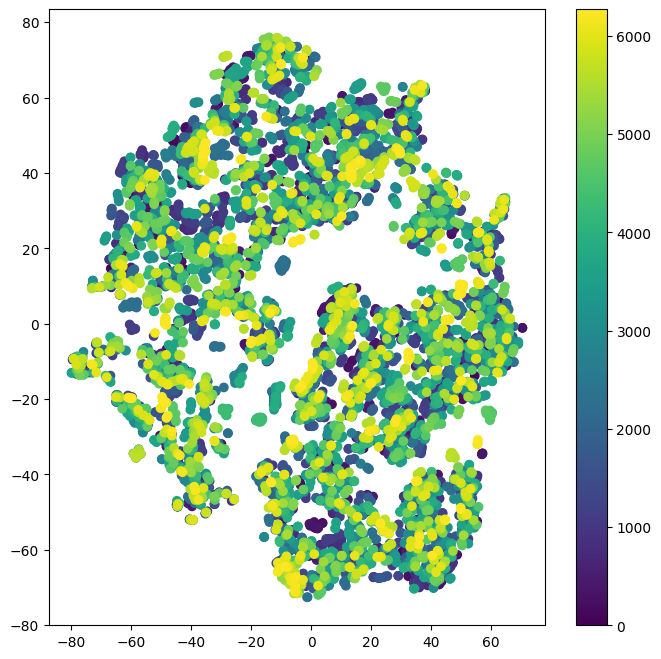

In [21]:
# plot embeddings
plt.figure(figsize=(8, 8))
color_indices = np.arange(len(tsne_embeddings))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=color_indices, cmap='viridis')
plt.colorbar()
plt.show()

In [9]:
del saved_model

: 